In [54]:
library(tidyverse)
library(repr)
library(tidymodels)

In [55]:
players_data <- read_csv("players.csv")|>
    select(-hashedEmail, -name, -gender)

head(players_data)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,played_hours,Age
<chr>,<lgl>,<dbl>,<dbl>
Pro,TRUE,30.3,9
Veteran,TRUE,3.8,17
Veteran,FALSE,0.0,17
Amateur,TRUE,0.7,21
Regular,TRUE,0.1,21
Amateur,TRUE,0.0,17


In [56]:
players_data$experience <- factor(players_data$experience,
                             levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro"),
                             labels = c(1, 2, 3, 4, 5))

head(players_data)

experience,subscribe,played_hours,Age
<fct>,<lgl>,<dbl>,<dbl>
5,TRUE,30.3,9
4,TRUE,3.8,17
4,FALSE,0.0,17
2,TRUE,0.7,21
3,TRUE,0.1,21
2,TRUE,0.0,17


In [57]:
players <- players_data |>
    mutate(experience = as.numeric(experience)) |>
    mutate(subscribe = as_factor(subscribe))

head(players)

experience,subscribe,played_hours,Age
<dbl>,<fct>,<dbl>,<dbl>
5,TRUE,30.3,9
4,TRUE,3.8,17
4,FALSE,0.0,17
2,TRUE,0.7,21
3,TRUE,0.1,21
2,TRUE,0.0,17


In [58]:
averages <- players|>
    summarize(avg_hrs = mean(played_hours, na.rm = TRUE), avg_age = mean(Age, na.rm = TRUE), avg_exp = mean(experience, na.rm = TRUE))
averages

avg_hrs,avg_age,avg_exp
<dbl>,<dbl>,<dbl>
5.845918,21.13918,2.709184


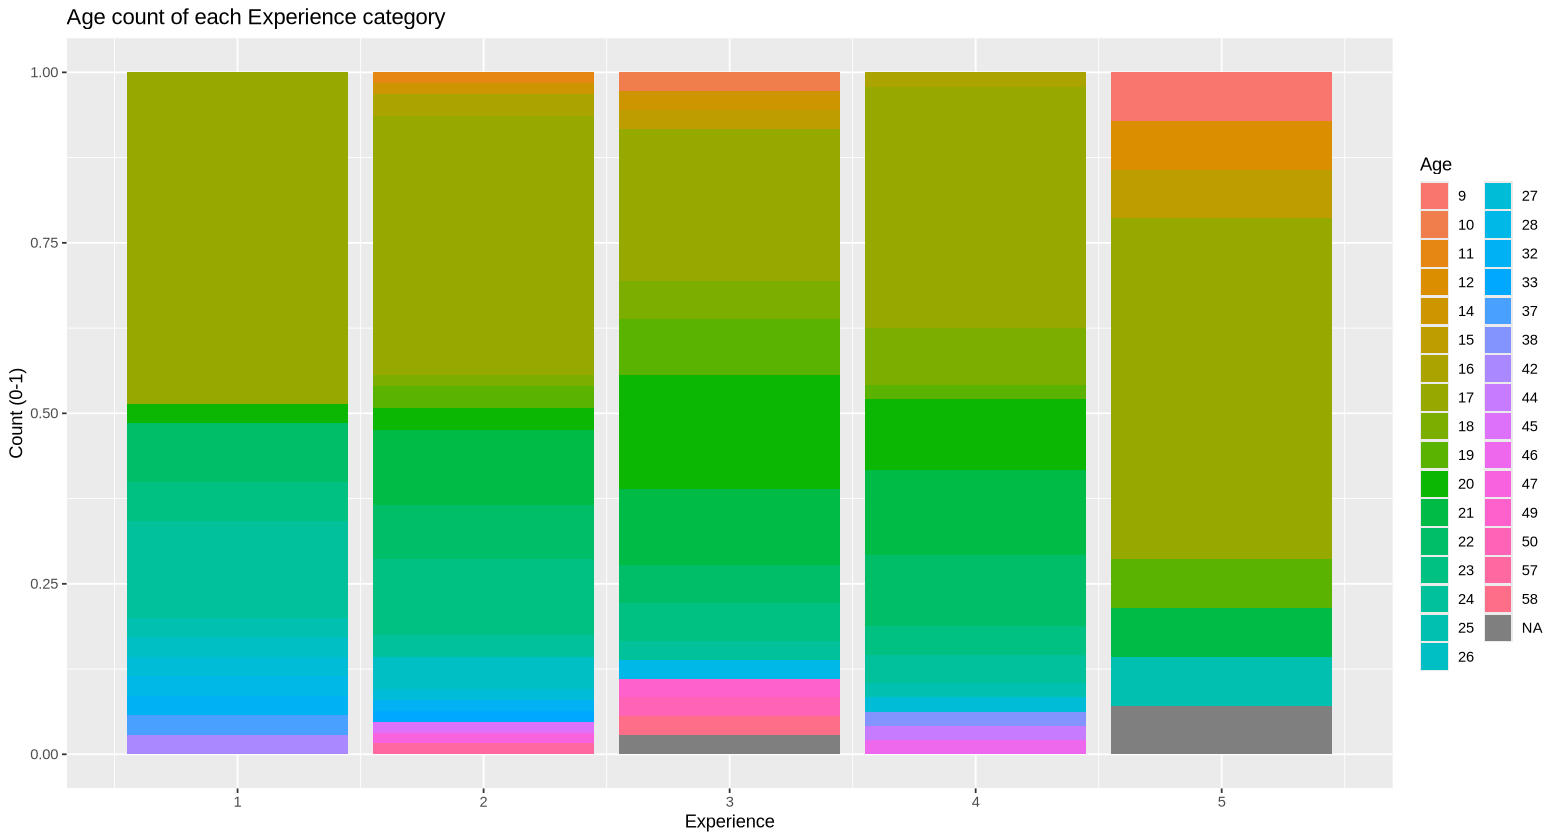

In [59]:
age_groups <- players |> 
    arrange(Age) |> 
    mutate(Age = as_factor(Age)) |>
    count(experience, Age)

age_exp_plot <- ggplot(age_groups, aes(x = experience, y = n, fill = Age)) + 
    geom_bar(stat = "identity", position = "fill") + 
    labs(x = "Experience", y = "Count (0-1)", fill = "Age", title = "Age count of each Experience category")
age_exp_plot

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


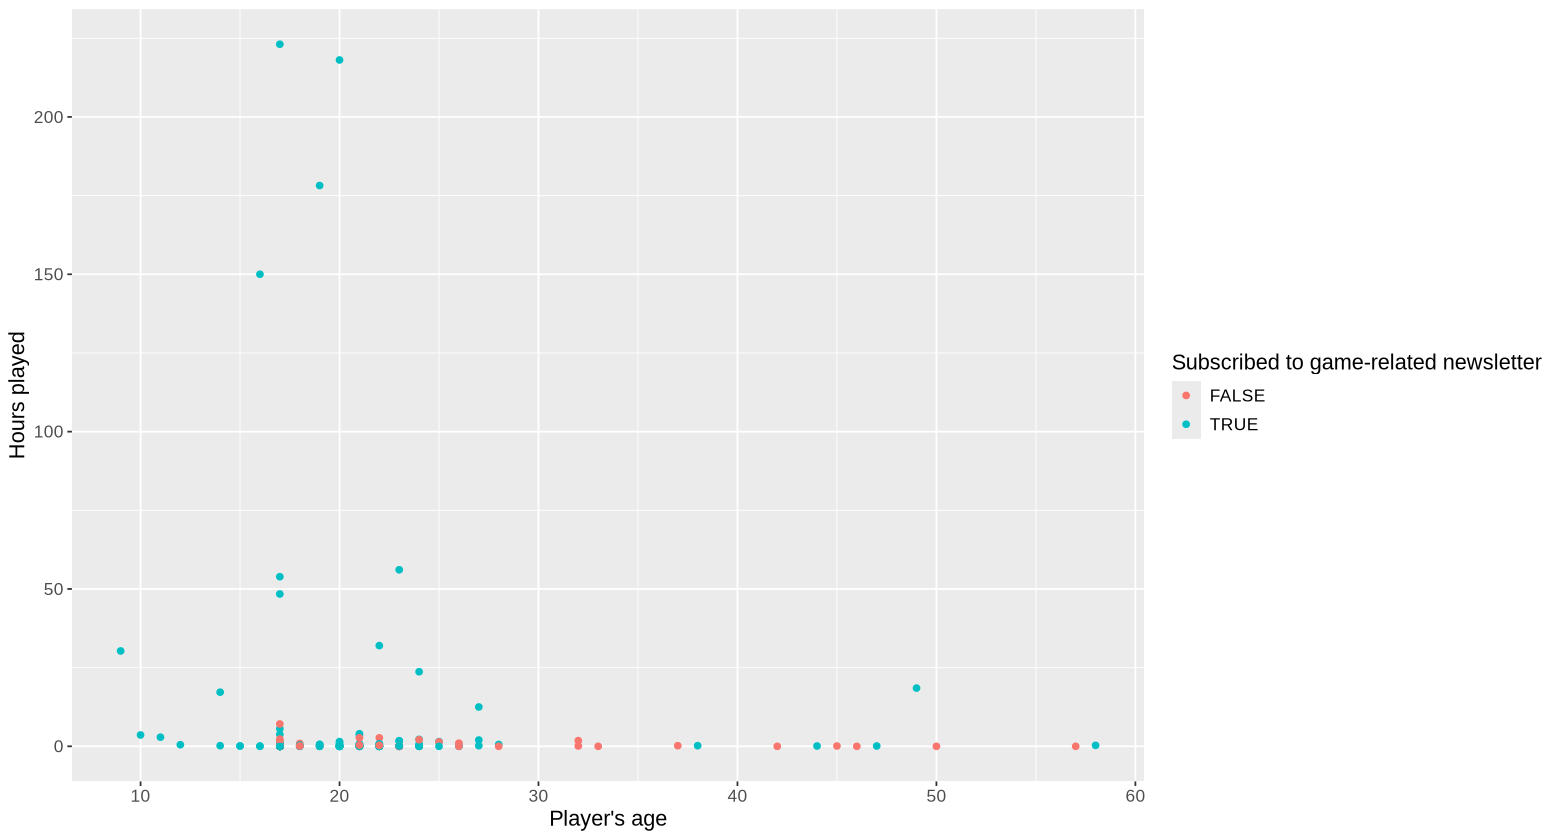

In [60]:
options(repr.plot.width = 13)

exploratory_plot <- players |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point() +
    labs(x = "Player's age", y = "Hours played", color = "Subscribed to game-related newsletter") +
    theme(text = element_text(size = 13))

exploratory_plot

In [61]:
# set the seed
set.seed(1)

# creating train / test split
players_split <- initial_split(players, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

In [62]:
# preprocessing
players_recipe <- recipe(subscribe ~ Age + played_hours, data = players_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  fit(data = players_train)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(3,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3931034
Best kernel: rectangular
Best k: 3

In [89]:
players_test_predictions <- predict(knn_fit, players_test) |>
    bind_cols(players_test)

players_test_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

players_test_predictions |> pull(subscribe) |> levels()

# positive label ('TRUE') is second level
players_test_predictions |>
    precision(truth = subscribe, estimate = .pred_class, event_level = "second") 

players_test_predictions |>
    recall(truth = subscribe, estimate = .pred_class, event_level = "second")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.4897959


[1] "FALSE" "TRUE"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.6896552


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.5555556


In [91]:
confusion <- players_test_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)

confusion

# note that the accuracy, precision, and recall are not very high

          Truth
Prediction FALSE TRUE
     FALSE     4   16
     TRUE      9   20